# Import Libraries

In [ ]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.utils import resample
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import OneHotEncoder
from nltk.probability import FreqDist
from matplotlib import cm
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from keras import models
from keras import layers
from keras import optimizers
from xgboost import XGBClassifier

# Obtain Data

Read Yelp review data from csv

In [ ]:
df = pd.read_csv('../Data/yelp_reviews.csv')
df.head()

,Category,Review
0,chinese,Classy and affordable - Buddakan is the perfec...
1,chinese,Buddakan was a great experience amid Covid-19....
2,chinese,By far one of my favorite restaurants in NYC. ...
3,chinese,Oh how I missed you New York Chinatown Chinese...
4,chinese,A solid four. I came solely for the xiao long ...


# Scrub Data: Pre-Processing

Create numerically encocded column for review class

In [ ]:
class_map = {'chinese': 0, 'japanese':1, 'indpak':2}
df['Class'] = df['Category'].replace(class_map)
df.iloc[1195:1205,:]

,Category,Review,Class
1195,chinese,Came across this new little shop while walking...,0
1196,chinese,Never knew this spot existed until I had to go...,0
1197,chinese,ive been here a few times now and the bings ar...,0
1198,chinese,I used to eat jian bing as breakfast when I li...,0
1199,chinese,"Great jianbing and service, perfect place for ...",0
1200,japanese,I've held off on posting this review for month...,1
1201,japanese,A New York must. Whether you're visiting from ...,1
1202,japanese,One of the best ramen in the city! Great choic...,1
1203,japanese,Mmm... still thinking about my meal days later...,1
1204,japanese,Just hear me out - everyone needs to calm down...,1


Create list of tokenized chinese restaurant reviews

In [ ]:
nltk.download('punkt')
chinese_reviews = list(df[df['Class'] == 0]['Review'].values)
chinese_tokens = []
for review in chinese_reviews:
    chinese_tokens.extend(nltk.word_tokenize(review))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Create list of tokenized japanese restaurant reviews

In [ ]:
japanese_reviews = list(df[df['Class'] == 1]['Review'].values)
japanese_tokens = []
for review in japanese_reviews:
    japanese_tokens.extend(nltk.word_tokenize(review))

Create list of tokenized indian restaurant reviews

In [ ]:
indian_reviews = list(df[df['Class'] == 2]['Review'].values)
indian_tokens = []
for review in indian_reviews:
    indian_tokens.extend(nltk.word_tokenize(review))

Remove stopwords from chinese, japanese and indian token lists

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['.','i',",",'!','s', '...',"'s","n't",'(',')',"'m",'ve',"i've", "i'm", 'food', 'place', 
                   'good', 'great', 'order', 'time', 'restaurant', 'restaurants', 'best', 'delicious', 'delivery',
                   'go', "it's",  'love', 'one', 'ordered', 'really', 'restaurants', 'spot', 'the', 'they', "they're",
                   "they'll", 'this', 'times', 'have', 'had', 'we', "we'll", "we've", 'always', 'came', 'come',
                   'friend', 'friends', "i'll", 'service', 'try', 'tried', 'tries', 'trying', '-', 'get', 'gets', 
                   'got', 'gotta', "i'd", "it'll", "it'd", 'like', 'likes', 'liked', 'the', "they've", "they'd",
                   "this'll", "this's", "you've", "we're", "we'd", 'review', 'reviews', 'reviewed', 'takeout', ':',
                   'my', 'favorite', 'lunch', '$', "'ve", 'I', 'It', 'My', 'The', 'They', 'This', 'We'])

filtered_chinese_tokens = []
for word in chinese_tokens:
    if word not in stop_words:
        filtered_chinese_tokens.append(word)
filtered_japanese_tokens = [] 
for word in japanese_tokens:
    if word not in stop_words:
        filtered_japanese_tokens.append(word)
filtered_indian_tokens = [] 
for word in indian_tokens:
    if word not in stop_words:
        filtered_indian_tokens.append(word)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Explore Data

Calculate shape and class distribution of Yelp dataset

In [ ]:
print('df shape:', df.shape)
df['Category'].value_counts()

df shape: (3560, 3)


chinese     1200
japanese    1200
indpak      1160
Name: Category, dtype: int64

Identify duplicate reviews in the dataset

In [ ]:
df[df.duplicated(keep=False)]

,Category,Review,Class
1239,japanese,I went there today for my second times this we...,1
1319,japanese,I went there today for my second times this we...,1


Remove duplicate reviews erroneously included in the dataset twice

In [ ]:
df = df[df.duplicated()==0]
print('df shape', df.shape)
df.head()

df shape (3559, 3)


,Category,Review,Class
0,chinese,Classy and affordable - Buddakan is the perfec...,0
1,chinese,Buddakan was a great experience amid Covid-19....,0
2,chinese,By far one of my favorite restaurants in NYC. ...,0
3,chinese,Oh how I missed you New York Chinatown Chinese...,0
4,chinese,A solid four. I came solely for the xiao long ...,0


Downsample Japanese and Chinese classes to match Indian class at 1160 datapoints

In [ ]:
ch_df = df[df['Category']=='chinese']
jp_df = df[df['Category']=='japanese']
in_df = df[df['Category']=='indpak']

jp_df = resample(jp_df, replace=False, n_samples=1160, random_state=11)
ch_df = resample(ch_df, replace=False, n_samples=1160, random_state=74)

df = pd.concat([ch_df, jp_df, in_df])

print('df shape:', df.shape)
print(df['Category'].value_counts())
df.head()

df shape: (3480, 3)
indpak      1160
chinese     1160
japanese    1160
Name: Category, dtype: int64


,Category,Review,Class
732,chinese,I love that there is an authentic Chinese rest...,0
809,chinese,I liked the dumplings!\n\nIt reminds me of dum...,0
521,chinese,I was invited back by the owner of South of th...,0
322,chinese,Review is for takeout only but because it was ...,0
58,chinese,"Even during Covid, their food is the BEST!!!! ...",0


Plot df class distribution

Text(0.5, 1.0, 'Restaurant Class Distribution')

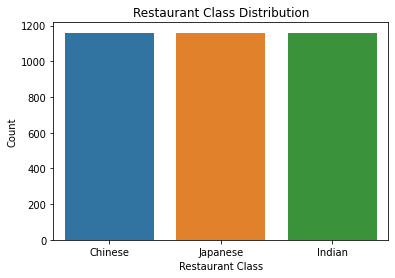

In [ ]:
fig, ax = plt.subplots()
sns.countplot(x='Category',data=df, ax=ax)
ax.set_xlabel('Restaurant Class')
ax.set_ylabel('Count')
ax.set_xticklabels(['Chinese', 'Japanese', 'Indian'])
ax.set_title('Restaurant Class Distribution')

Create lists of 25 most frequent words and word counts by class

In [ ]:
chinese_freq = FreqDist(filtered_chinese_tokens)
japanese_freq = FreqDist(filtered_japanese_tokens)
indian_freq = FreqDist(filtered_indian_tokens)
chinese_freq_words = [x[0] for x in chinese_freq.most_common(25)]
chinese_freq_counts = [x[1] for x in chinese_freq.most_common(25)]
japanese_freq_words = [x[0] for x in japanese_freq.most_common(25)]
japanese_freq_counts = [x[1] for x in japanese_freq.most_common(25)]
indian_freq_words = [x[0] for x in indian_freq.most_common(25)]
indian_freq_counts = [x[1] for x in indian_freq.most_common(25)]

Create frequency distribution bar graphs for 25 most frequent words by class

Text(0, 0.5, 'Frequency')

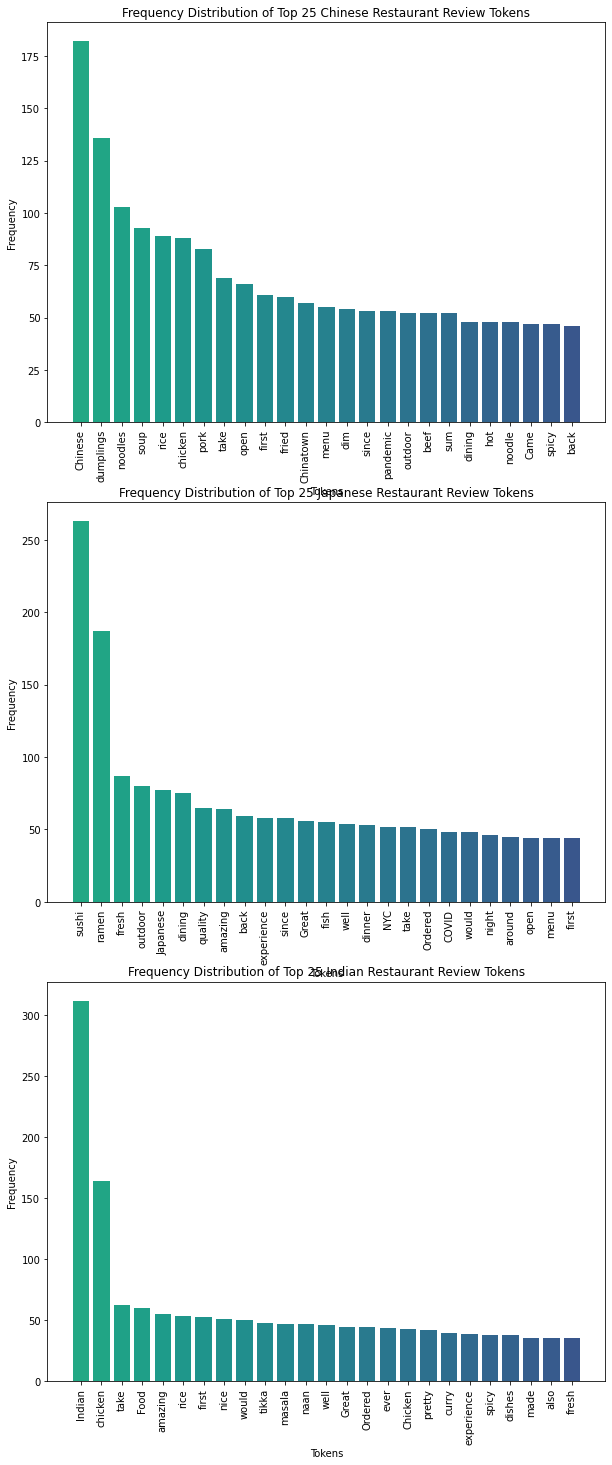

In [ ]:
color = cm.viridis_r(np.linspace(.4,.8, 30))
fig, ax = plt.subplots(nrows = 3, ncols=1, figsize=(10,25))
ax[0].bar(chinese_freq_words, chinese_freq_counts, color=color)
ax[0].set_xticklabels(labels=chinese_freq_words, rotation=90)
ax[0].set_title('Frequency Distribution of Top 25 Chinese Restaurant Review Tokens')
ax[0].set_xlabel('Tokens')
ax[0].set_ylabel('Frequency')
ax[1].bar(japanese_freq_words, japanese_freq_counts, color=color)
ax[1].set_xticklabels(labels=japanese_freq_words, rotation=90)
ax[1].set_title('Frequency Distribution of Top 25 Japanese Restaurant Review Tokens')
ax[1].set_xlabel('Tokens')
ax[1].set_ylabel('Frequency')
ax[2].bar(indian_freq_words, indian_freq_counts, color=color)
ax[2].set_xticklabels(labels=indian_freq_words, rotation=90)
ax[2].set_title('Frequency Distribution of Top 25 Indian Restaurant Review Tokens')
ax[2].set_xlabel('Tokens')
ax[2].set_ylabel('Frequency')

Create word clouds for 25 most frequent words by class

[]

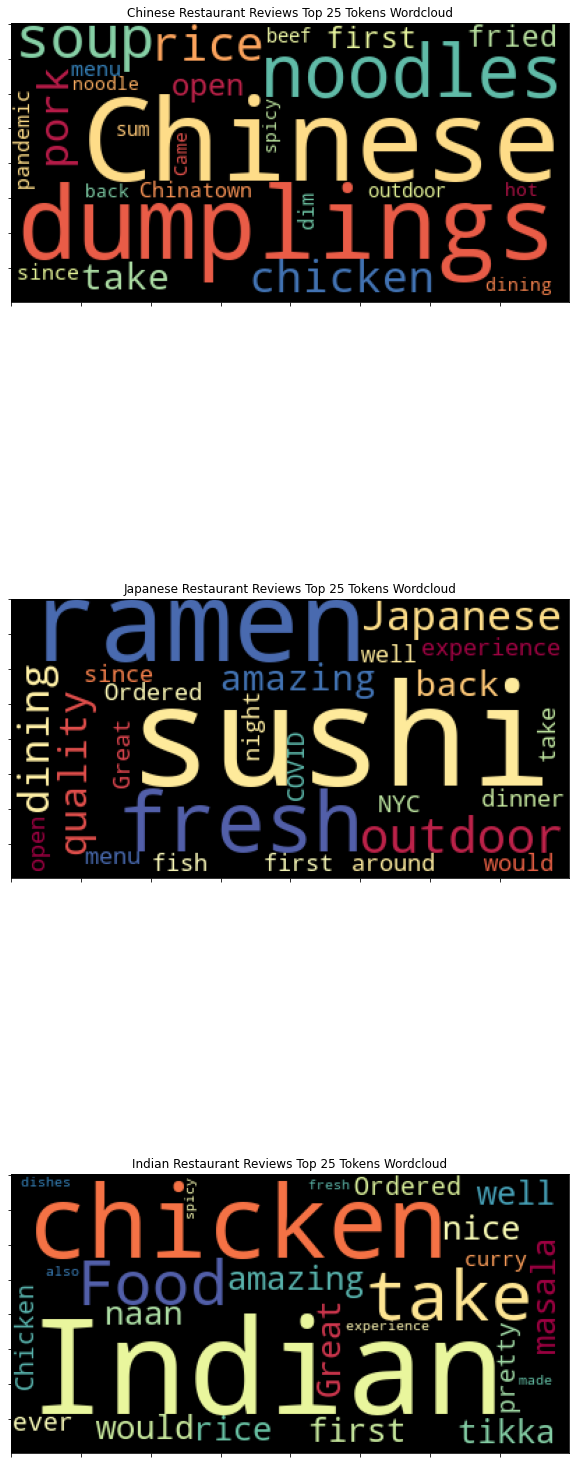

In [ ]:
chinese_freq_zipped = dict(zip(chinese_freq_words, chinese_freq_counts))
japanese_freq_zipped = dict(zip(japanese_freq_words, japanese_freq_counts))
indian_freq_zipped = dict(zip(indian_freq_words, indian_freq_counts))
chinese_wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(chinese_freq_zipped)
japanese_wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(japanese_freq_zipped)
indian_wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(indian_freq_zipped)
fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(10,30))
ax[0].imshow(chinese_wordcloud)
ax[0].set_title('Chinese Restaurant Reviews Top 25 Tokens Wordcloud')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[1].imshow(japanese_wordcloud)
ax[1].set_title('Japanese Restaurant Reviews Top 25 Tokens Wordcloud')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[2].imshow(indian_wordcloud)
ax[2].set_title('Indian Restaurant Reviews Top 25 Tokens Wordcloud')
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])

# Model Data

Split Yelp review data into x and y variables

In [ ]:
x = df['Review'].values
y = df['Class'].values

Perform train test split on Yelp review data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

Vectorize Yelp review data using tf-idf

In [ ]:
vectorizer = TfidfVectorizer(stop_words = stop_words)
vectorizer.fit(x_train)
tfidf_x_train = vectorizer.transform(x_train)
tfidf_x_test = vectorizer.transform(x_test)

Calculate shape of x_train and x_test

In [ ]:
print('train shape: ', tfidf_x_train.shape)
print('test shape: ', tfidf_x_test.shape)

train shape:  (2610, 5142)
test shape:  (870, 5142)


Train baseline Dummy Classifier for Yelp review data

In [ ]:
dummy = DummyClassifier(random_state=78, strategy='stratified')
dummy.fit(tfidf_x_train, y_train)
y_train_pred_dummy = dummy.predict(tfidf_x_train)
y_test_pred_dummy = dummy.predict(tfidf_x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred_dummy, average='weighted'))
print('Test F1 Score: ', f1_score(y_test, y_test_pred_dummy, average='weighted'))

Train F1 Score:  0.33630884640755
Test F1 Score:  0.3227541687035473


Perform GridSearchCV on Naive Bayes to find optimal alpha value

In [ ]:
nb_dict = {'alpha': [x/100 for x in range(0, 501)]}
gs_nb = MultinomialNB()
gs_nb = GridSearchCV(gs_nb, nb_dict, scoring='f1_weighted', n_jobs=-1, cv=5, verbose=1)
gs_nb.fit(tfidf_x_train, y_train)
print(gs_nb.best_params_)
print(gs_nb.best_score_)

Fitting 5 folds for each of 501 candidates, totalling 2505 fits
{'alpha': 0.95}
0.7206604621714348


Train Naive Bayes model based on optimal alpha value from GridsearchCV

In [ ]:
nb = MultinomialNB(alpha=.95)
nb.fit(tfidf_x_train, y_train)
y_train_pred = nb.predict(tfidf_x_train)
y_test_pred = nb.predict(tfidf_x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1 Score: ', f1_score(y_test, y_test_pred, average='weighted'))

Train F1 Score:  0.9279013439313175
Test F1 Score:  0.7449020740097766


Create Confusion Matrix for Naive Bayes model

[Text(0, 0.5, 'Chinese'), Text(0, 1.5, 'Japanese'), Text(0, 2.5, 'Indian')]

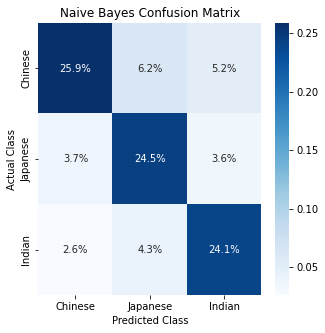

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Naive Bayes Confusion Matrix')
matrix.set_xlabel('Predicted Class')
matrix.set_xticklabels(['Chinese','Japanese', 'Indian'])
matrix.set_ylabel('Actual Class')
matrix.set_yticklabels(['Chinese','Japanese', 'Indian'])

Perform GridSearchCV on Adaboost to find optimal hyperparameters

In [ ]:
ab_dict = {'learning_rate': [x/100 for x in range(160, 211, 2)], 
           'algorithm': ['SAMME', 'SAMME.R'],
           'n_estimators': [250, 350, 450]}
gs_ab = AdaBoostClassifier(random_state=27)
gs_ab = GridSearchCV(gs_ab, ab_dict, scoring='f1_weighted', n_jobs=-1, cv=5, verbose=1)
gs_ab.fit(tfidf_x_train, y_train)
print(gs_ab.best_params_)
print(gs_ab.best_score_)

Fitting 5 folds for each of 156 candidates, totalling 780 fits
{'algorithm': 'SAMME', 'learning_rate': 1.82, 'n_estimators': 350}
0.6795644487402156


Train Adaboost model on GridsearchCV results

In [ ]:
ab = AdaBoostClassifier(learning_rate=1.82, n_estimators=350, algorithm='SAMME', random_state=27)
ab.fit(tfidf_x_train, y_train)
y_train_pred_ab = ab.predict(tfidf_x_train)
y_test_pred_ab = ab.predict(tfidf_x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred_ab, average='weighted'))
print('Test F1 Score: ', f1_score(y_test, y_test_pred_ab, average='weighted'))

Train F1 Score:  0.73584319654534
Test F1 Score:  0.6875215313825467


Create Confusion Matrix for Adaboost model

[Text(0, 0.5, 'Chinese'), Text(0, 1.5, 'Japanese'), Text(0, 2.5, 'Indian')]

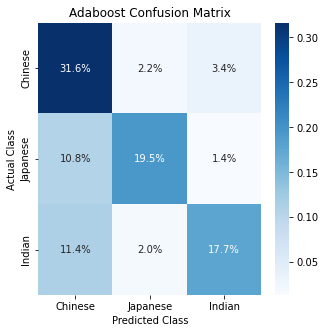

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_ab)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Adaboost Confusion Matrix')
matrix.set_xlabel('Predicted Class')
matrix.set_xticklabels(['Chinese','Japanese', 'Indian'])
matrix.set_ylabel('Actual Class')
matrix.set_yticklabels(['Chinese','Japanese', 'Indian'])

Perform GridSearchCV on Random Forest to find optimal hyperparameters

In [ ]:
rf_dict = {'max_features': [.0013, .0014, .0015, .0016, .0017], 
           'max_samples': [.89, .895, .9, .905, .91],
           'min_samples_split': [9, 10, 11, 12, 13],
           'criterion': ['gini', 'entropy']}
gs_rf = RandomForestClassifier(random_state=47)
gs_rf = GridSearchCV(gs_rf, rf_dict, scoring='f1_weighted', n_jobs=-1, cv=5, verbose=1)
gs_rf.fit(tfidf_x_train, y_train)
print(gs_rf.best_params_)
print(gs_rf.best_score_)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
{'criterion': 'entropy', 'max_features': 0.0014, 'max_samples': 0.9, 'min_samples_split': 11}
0.7251475374501049


Train Random Forest Classifier based on GridsearchCV results

In [ ]:
rf = RandomForestClassifier(criterion='entropy', max_features=.0014, random_state=47,
                            max_samples=.9, min_samples_split=11)
rf.fit(tfidf_x_train, y_train)
y_train_pred_rf = rf.predict(tfidf_x_train)
y_test_pred_rf = rf.predict(tfidf_x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred_rf, average='weighted'))
print('Test F1 Score: ', f1_score(y_test, y_test_pred_rf, average='weighted'))

Train F1 Score:  0.9923264505986
Test F1 Score:  0.733556787736541


Create Confusion Matrix for Random Forest model

[Text(0, 0.5, 'Chinese'), Text(0, 1.5, 'Japanese'), Text(0, 2.5, 'Indian')]

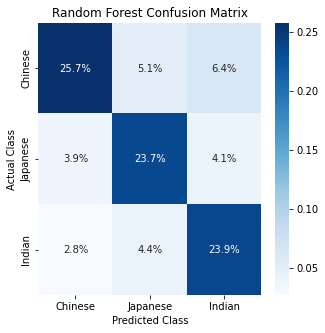

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_rf)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Random Forest Confusion Matrix')
matrix.set_xlabel('Predicted Class')
matrix.set_xticklabels(['Chinese','Japanese', 'Indian'])
matrix.set_ylabel('Actual Class')
matrix.set_yticklabels(['Chinese','Japanese', 'Indian'])

Gridsearch xgboost model

In [ ]:
xgb_dict = {'learning_rate': [.1075, .11, .1125],
            'subsample': [.8925, .895, .8975],
           'colsample_bynode': [.02875, .029, .02925],
            'gamma': [.634, .635, .636],
            'reg_lambda': [.083, .084, .085]}
gs_xgb = XGBClassifier(random_state=21)
gs_xgb = GridSearchCV(gs_xgb, xgb_dict, scoring='f1_weighted', n_jobs=-1, cv=5, verbose=1)
gs_xgb.fit(tfidf_x_train, y_train)
print(gs_xgb.best_params_)
print(gs_xgb.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
{'colsample_bynode': 0.029, 'gamma': 0.635, 'learning_rate': 0.11, 'reg_lambda': 0.084, 'subsample': 0.895}
0.7106144137375603


Build and validate top performing xgboost model

In [ ]:
xgb = XGBClassifier(colsample_bynode=0.029, gamma=.635, learning_rate=0.11, reg_lambda=.084, subsample=0.895,
                    random_state=21)
xgb.fit(tfidf_x_train, y_train)
y_train_pred_xgb = xgb.predict(tfidf_x_train)
y_test_pred_xgb = xgb.predict(tfidf_x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred_xgb, average='weighted'))
print('Test F1 Score: ', f1_score(y_test, y_test_pred_xgb, average='weighted'))

Train F1 Score:  0.8124553623665762
Test F1 Score:  0.7094459045709717


Create confusion matrix for XGBoost

[Text(0, 0.5, 'Chinese'), Text(0, 1.5, 'Japanese'), Text(0, 2.5, 'Indian')]

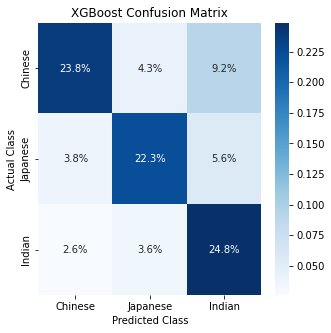

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_xgb)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('XGBoost Confusion Matrix')
matrix.set_xlabel('Predicted Class')
matrix.set_xticklabels(['Chinese','Japanese', 'Indian'])
matrix.set_ylabel('Actual Class')
matrix.set_yticklabels(['Chinese','Japanese', 'Indian'])

Train voting classifier model

In [ ]:
vc = VotingClassifier(estimators=[('nb', nb), ('rf', rf), ('xgb', xgb)], voting='soft', weights=[.5, .4, .15])
vc.fit(tfidf_x_train, y_train)
y_train_pred_vc = vc.predict(tfidf_x_train)
y_test_pred_vc = vc.predict(tfidf_x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred_vc, average='weighted'))
print('Train Accuracy: ', accuracy_score(y_train, y_train_pred_vc))
print('Test F1 Score: ', f1_score(y_test, y_test_pred_vc, average='weighted'))
print('Test Accuracy: ', accuracy_score(y_test, y_test_pred_vc))

Train F1 Score:  0.9800349118497403
Train Accuracy:  0.9800766283524904
Test F1 Score:  0.7616148812465828
Test Accuracy:  0.7620689655172413


Create Confusion Matrix for Voting Classifier model

[Text(0, 0.5, 'Chinese'), Text(0, 1.5, 'Japanese'), Text(0, 2.5, 'Indian')]

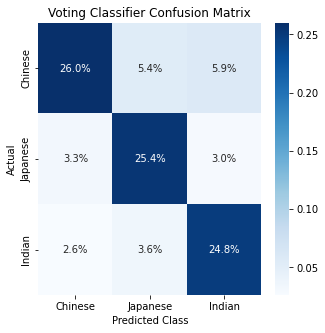

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_vc)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Voting Classifier Confusion Matrix')
matrix.set_xlabel('Predicted Class')
matrix.set_xticklabels(['Chinese','Japanese', 'Indian'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Chinese','Japanese', 'Indian'])

# Analyze Results

Create df with inverse document frequency by word

In [ ]:
idf_df = pd.DataFrame(vectorizer.idf_, index=vectorizer.get_feature_names(), columns=['IDF']).sort_values(by='IDF')
idf_df.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,IDF
covid,3.272777
indian,3.399428
chicken,3.442539
sushi,3.564184
take,3.824063
fresh,3.940235
rice,3.947508
amazing,3.962214
chinese,4.015458
first,4.039175


Calculate Naive Bayes feature probabilities for top 10 document frequency features

In [ ]:
nb_prob_df = pd.DataFrame(nb.feature_log_prob_, columns=vectorizer.get_feature_names(), index=['Chinese', 'Japanese', 'Indian']).T
nb_prob_df_10 = nb_prob_df.loc[idf_df.head(10).index]
nb_prob_df_10 = np.exp(nb_prob_df_10)
nb_prob_df_10.reset_index(drop=False, inplace=True)
nb_prob_df_10.rename(columns={'index': 'Word'}, inplace=True)
nb_prob_df_10

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word,Chinese,Japanese,Indian
0,covid,0.002192,0.002889,0.001298
1,indian,0.000208,0.000123,0.006045
2,chicken,0.001764,0.000673,0.003744
3,sushi,0.000362,0.005544,0.000123
4,take,0.001671,0.001402,0.001440
5,fresh,0.001168,0.002350,0.000780
6,rice,0.001923,0.000953,0.001255
7,amazing,0.001030,0.001564,0.001653
8,chinese,0.003589,0.000195,0.000333
9,first,0.001318,0.001215,0.001275


Plot top 10 highest document frequency naive bayes 

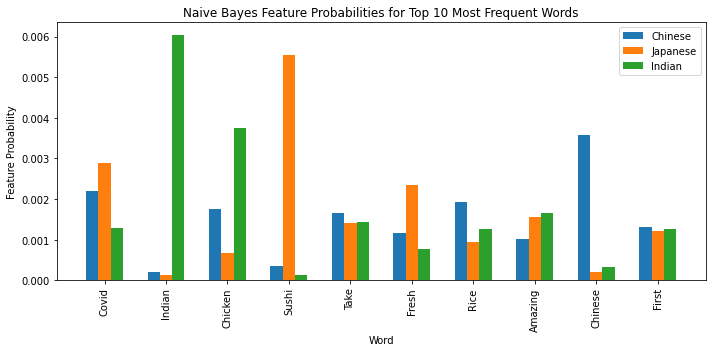

In [ ]:
x = np.arange(len(nb_prob_df_10['Word']))
width = 0.2 

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width, nb_prob_df_10['Chinese'], width, label='Chinese')
rects2 = ax.bar(x, nb_prob_df_10['Japanese'], width, label='Japanese')
rects3 = ax.bar(x + width, nb_prob_df_10['Indian'], width, label='Indian')

ax.set_ylabel('Feature Probability')
ax.set_xlabel('Word')
ax.set_title('Naive Bayes Feature Probabilities for Top 10 Most Frequent Words')
tick_labels = [x.title() for x in list(nb_prob_df_10['Word'].values)]
ax.set_xticks(x)
ax.set_xticklabels(tick_labels, rotation=90)
ax.legend()
fig.tight_layout()

plt.show()

Calculate Random Forest feature importances

In [ ]:
rf_importances_df = pd.DataFrame(rf.feature_importances_, index=vectorizer.get_feature_names()).sort_values(by=0, ascending=False)
rf_importances_df.reset_index(inplace=True)
rf_importances_df.columns=['Word', 'Importance']
rf_importances_df.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word,Importance
0,indian,0.017662
1,sushi,0.016601
2,ramen,0.012470
3,chinese,0.011085
4,dumplings,0.007745
5,japanese,0.006346
6,chicken,0.005892
7,noodles,0.005822
8,masala,0.005620
9,pork,0.004584


Plot Random Forest feature importances

[Text(0, 0, 'Indian'),
 Text(0, 0, 'Sushi'),
 Text(0, 0, 'Ramen'),
 Text(0, 0, 'Chinese'),
 Text(0, 0, 'Dumplings'),
 Text(0, 0, 'Japanese'),
 Text(0, 0, 'Chicken'),
 Text(0, 0, 'Noodles'),
 Text(0, 0, 'Masala'),
 Text(0, 0, 'Pork'),
 Text(0, 0, 'Omakase'),
 Text(0, 0, 'Chinatown'),
 Text(0, 0, 'Tikka'),
 Text(0, 0, 'Dim'),
 Text(0, 0, 'Naan'),
 Text(0, 0, 'Fresh'),
 Text(0, 0, 'Biryani'),
 Text(0, 0, 'Covid'),
 Text(0, 0, 'Noodle'),
 Text(0, 0, 'Fish')]

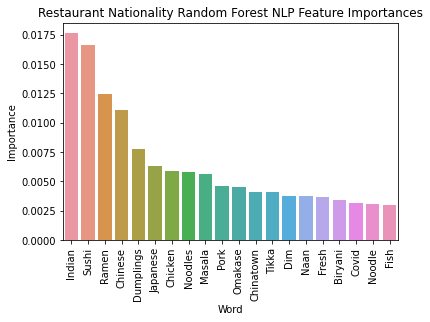

In [ ]:
fig, ax = plt.subplots()
sns.barplot(x='Word',y='Importance', data=rf_importances_df.head(20), ax=ax)
ax.set_title('Restaurant Nationality Random Forest NLP Feature Importances')
rf_tick_labels = [x.title() for x in rf_importances_df.head(20)['Word']]
ax.set_xticklabels(rf_tick_labels, rotation=90)